# 2048 Reinforcement learning

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from model.game import Game2048, UP, DOWN, LEFT, RIGHT
from player import play_many

## Hard-coded strategie

In [3]:
class RandomStrategy:
    def get_action(self, game):
        return np.random.randint(4)

In [6]:
class DumbStrategy:
    def get_action(self, game):
        grid = game.grid

        scores = sorted([
            (-grid[0:2].sum(), UP),
            (-grid[2:4].sum(), DOWN),
            (-grid[:,0:2].sum(), LEFT),
            (-grid[:,2:4].sum(), RIGHT),
        ])
        
        choice = None
        idx = 0
        while choice is None:
            _, direction = scores[idx]
            if game.can_move(direction):
                choice = direction
            idx += 1

        return choice

In [10]:
%%time

# strategy = RandomStrategy()
strategy = DumbStrategy()

df = play_many(1000, strategy)

CPU times: user 37 s, sys: 249 ms, total: 37.2 s
Wall time: 36.9 s


In [11]:
df.describe()

,score,max_tile,moves
count,1000.000000,1000.000000,1000.000000
mean,2612.800000,203.712000,230.004000
std,1223.285757,96.855945,79.517375
min,376.000000,32.000000,68.000000
25%,1688.000000,128.000000,172.000000
50%,2528.000000,256.000000,222.000000
75%,3368.000000,256.000000,281.250000
max,7536.000000,512.000000,523.000000


In [12]:
df.moves.sum()

230004

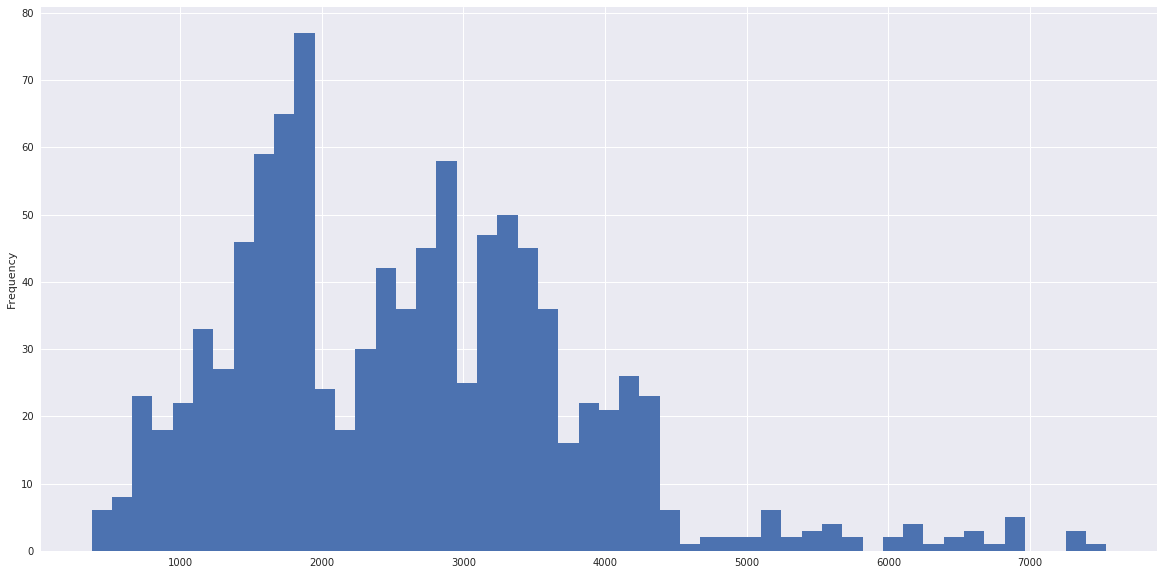

In [13]:
df.score.plot(kind='hist', bins=50)

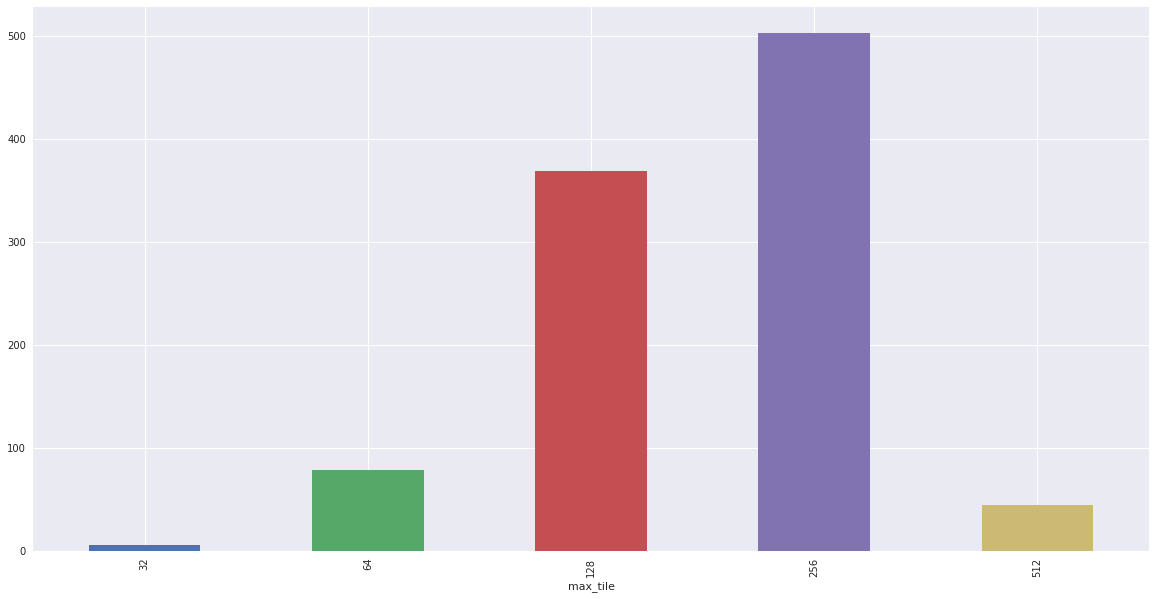

In [14]:
df.groupby(df.max_tile).score.count().plot.bar()

In [15]:
df.groupby(df.max_tile).score.count()

max_tile
32       6
64      78
128    369
256    503
512     44
Name: score, dtype: int64